# 语言模型和数据集
## 1、学习语言模型
面对的问题是如何对一个文档，甚至是一串标记进行建模。

## 2、马尔可夫模型与n元语法
一阶马尔可夫性质：P(xt+1∣xt,…,x1)=P(xt+1∣xt) ，

推导:
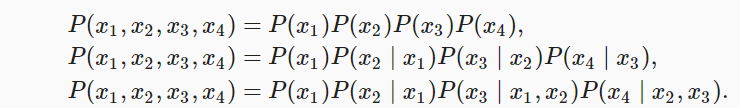
涉及一个、两个和三个变量的概率公式通常分别称为“一元语法”（unigram）、“二元语法”（bigram）和“三元语法”（trigram）。

## 3、自然语言统计
最流行的词看起来很无聊。它们通常被称为“停用词”（stop words），因此可以被过滤掉。

In [1]:
import random
import torch
from d2l import torch as d2l
import sys
sys.path.append('../../CommonFunctions/tools/')
import sequence_tools
import common_tools

In [2]:
tokens = sequence_tools.tokenize(sequence_tools.read_time_machine())
# 因为每个文本不一定是一个句子或者段落，因此我们把所有文本行连接在一起
corpus = [token for line in tokens for token in line]
vocab = sequence_tools.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

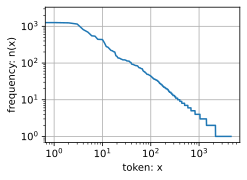

In [3]:
# 词频图
freqs = [freq for token, freq in vocab.token_freqs]
common_tools.plot(freqs, xlabel='token: x', 
                  ylabel='frequency: n(x)', 
                  xscale='log', yscale='log')

看到了一些非常基本的东西：词频以一种明确的方式迅速衰减。

将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。这意味着单词符合 齐普夫定律（Zipf’s law），即第  i  个最常用单词的频率  ni  为：
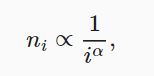
相当于：
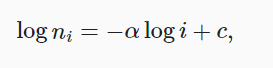
其中  α  是表征分布的指数， c  是常数。让我们明白想要通过计数统计和平滑来建模单词是不可行的。结果，我们会大大高估尾部单词的频率，也就是所谓的不常用单词。

In [4]:
# 二元语法的频率
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = sequence_tools.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [5]:
# 三元频率
trigram_tokens = [triple for triple in zip(corpus[:-2], 
                                          corpus[1:-1], corpus[2:])]
trigram_vocab = sequence_tools.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

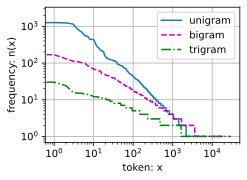

In [6]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

这张图相当令人激动，原因则有很多。首先，除了单字词，单词序列似乎也遵循齐普夫定律，尽管公式 (8.3.7) 中的指数  α  更小（指数的大小取决于序列的长度）。其次，词典中  n  元组的数量并没有那么大，说明语言中存在相当多的结构，这给了我们应用模型希望。第三，很多  n  元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。作为代替，我们将使用基于深度学习的模型。

## 4、读取长序列数据

### 随机采样
在随机采样中，每个样本都是在原始长序列上任意捕获的子序列。在迭代期间，来自两个相邻的、随机的小批量中的子序列不一定在原始序列上相邻。对于语言建模，目标是根据到目前为止我们看到的标记来预测下一个标记，因此标签是移位了一个标记的原始序列。

每次都从数据中随机生成一个小批量。这里，参数 batch_size 指定了每个小批量中的子序列样本的数目，num_steps 是每个子序列中预定义的时间步数。

In [7]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列。"""
    # 从随机偏移量（包括`num_steps - 1`）开始对序列进行分区
    corpus = corpus[random.randint(0, num_steps - 1):]
    print('corpus:', corpus)
    # 减去1，因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    print('num_subseqs:', num_subseqs)
    # 长度为`num_steps`的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    print('initial_indices: ', initial_indices)
    # 在随机抽样中，
    # 迭代过程中两个相邻的、随机的小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从`pos`开始的长度为`num_steps`的序列
        return corpus[pos:pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 这里，`initial_indices`包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        print('initial_indices_per_batch: ', initial_indices_per_batch)
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [8]:
my_seq = list(range(35))
print('my_seq: ', my_seq)
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

my_seq:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
corpus: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
num_subseqs: 6
initial_indices:  [0, 5, 10, 15, 20, 25]
initial_indices_per_batch:  [15, 10]
X:  tensor([[16, 17, 18, 19, 20],
        [11, 12, 13, 14, 15]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16]])
initial_indices_per_batch:  [20, 5]
X:  tensor([[21, 22, 23, 24, 25],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[22, 23, 24, 25, 26],
        [ 7,  8,  9, 10, 11]])
initial_indices_per_batch:  [0, 25]
X:  tensor([[ 1,  2,  3,  4,  5],
        [26, 27, 28, 29, 30]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [27, 28, 29, 30, 31]])


### 顺序区分
保证在迭代过程中两个相邻的小批量中的子序列在原始序列上是相邻的。

In [9]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列。"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X, Y

In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [11]:
class SeqDataLoader: #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = sequence_tools.seq_data_iter_random
        else:
            self.data_iter_fn = sequence_tools.seq_data_iter_sequential
        self.corpus, self.vocab = sequence_tools.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

定义了一个函数 load_data_time_machine ，它同时返回数据迭代器和词汇表。

In [12]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000): #@save
    """返回时光机器数据集的迭代器和词汇表"""
    data_iter = SeqDataLoader(batch_size, num_steps, 
                              use_random_iter, max_tokens)
    return data_iter, data_iter.vocab
    